# Antarctic Peninsula greening from Landsat
Revisiting trends computed by Roland et al. 2024 (https://doi.org/10.1038/s41561-024-01564-5) (hereafter R24)

In [1]:
import pandas as pd
import numpy as np
import pymannkendall as mk
from matplotlib import pyplot as plt

## Read NDVI tables
Run Earth Engine code from https://github.com/OllyBartlett/Roland_And_Bartlett_et_al_2024/

then replace 
```javascript
var composite = filtered.select('NDVI').reduce(ee.Reducer.max());
```
by
```javascript
var composite = filtered.select('NDVI').reduce(ee.Reducer.mean());
```

Generate two tables ```GAP_maxNDVI_Area.csv``` and ```GAP_meanNDVI_Area.csv```

In [2]:
def readcsv(s):
    '''
    read GAP_{mean,max}NDVI_Area.csv table
    '''
    df = pd.read_csv(s, index_col='system:index', usecols = lambda x: x.startswith(('system:index','NDVI')))
    df['method'] = s.split('_')[1]
    return df

In [3]:
# concatenate both tables in the same dataframe and add a "method" key (mean or max)
df = pd.concat(map(readcsv,['GAP_maxNDVI_Area.csv','GAP_meanNDVI_Area.csv']))

## Total area analysis

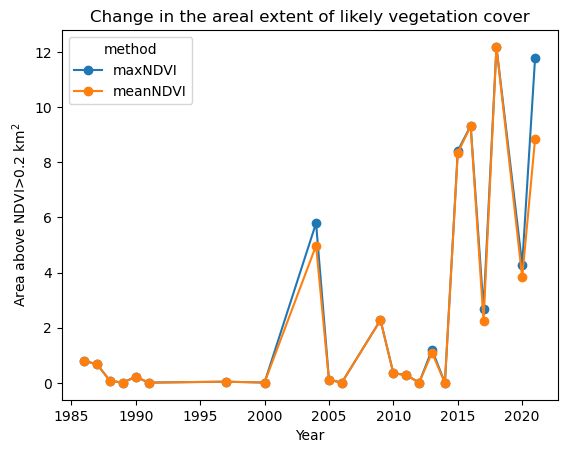

In [4]:
# sum areas with NDVI>0.2 
dfy = df.groupby(by='method').agg(lambda x:1e-6*sum(x)).filter(regex='NDVI').T
# creates an year index
dfy.index = pd.to_datetime(dfy.index,format='NDVI_Area_%Y').year
# plot
dfy.plot(
    title='Change in the areal extent of likely vegetation cover',
    marker='o',
    ylabel='Area above NDVI>0.2 km$^2$',
    xlabel='Year');

In [5]:
def areaChange(period):
    '''
    Area change in km2/decade 
    '''
    y1, y2 = period
    return pd.DataFrame({f'{y1}-{y2}':dfy.apply(lambda x:10*(x.loc[y2]-x.loc[y1])/(y2-y1), axis=0)}).T

def mannKendall(x):
    '''
    Mann-Kendall test
    '''
    test = mk.original_test(x)
    return pd.Series({'z (${\\tau}$)':test.z, 'p':test.p})

def lsTrend(x):
    '''
    Least-square trend in km2/decade
    '''
    return pd.Series({'trend':10*np.polyfit(x.index,x.values,1)[0]})

Attempt to reproduce R24 Supp. Table 5.2, where MK's $z$ statistics is called ${\\tau}$ 

In [6]:
t52 = pd.Series({'z (${\\tau}$)':2.31, 'p':0.021})
dt52 = dfy.apply(mannKendall, axis=0)
dt52['maxNDVI (R24)'] = t52
dt52.style.set_caption(mannKendall.__doc__)

method,maxNDVI,meanNDVI,maxNDVI (R24)
z (${\tau}$),2.271299,2.218478,2.310000
p,0.023129,0.026522,0.021000


Another attempt to reproduce R24 Supp. Table 5.2 by filling no-data years with zeroes 
as per R24 "Trend analysis was conducted on the maximum annual area, with no-data years 
treated as zeroes, using a 1 year time interval"

In [7]:
dt52 = dfy.reindex(range(1986,2022), fill_value=0).apply(mannKendall, axis=0)
dt52['maxNDVI (R24)'] = t52
dt52.style.set_caption(mannKendall.__doc__)

method,maxNDVI,meanNDVI,maxNDVI (R24)
z (${\tau}$),2.137597,2.109470,2.310000
p,0.032550,0.034904,0.021000


Compute slope of the least-square regression line for both methods (not reported by R42)

In [8]:
dfy.apply(lsTrend, axis=0).style.set_caption(lsTrend.__doc__)

method,maxNDVI,meanNDVI
trend,1.992376,1.797079


Area changes by period (reproduce Tab. 5.1 in R24)

In [9]:
periods = (1986, 2021), (1986, 2004), (2004, 2016), (2016, 2021)
pd.concat(map(areaChange,periods)).style.set_caption(areaChange.__doc__)

method,maxNDVI,meanNDVI
1986-2021,3.135337,2.297203
1986-2004,2.772457,2.319422
2004-2016,2.941333,3.610947
2016-2021,4.907314,-0.935774


## Number of observations analysis

The same GEE code was adapted to compute the average number of clear observations by polygon
```javascript
var composite = filtered.select('NDVI').reduce(ee.Reducer.count());
```
- code: https://code.earthengine.google.com/5f502d523fe82607c58311d45ef6e138
- output: ```GAP_countNDVI_Area.csv``` 

In [10]:
dc = readcsv('GAP_countNDVI_Area.csv')

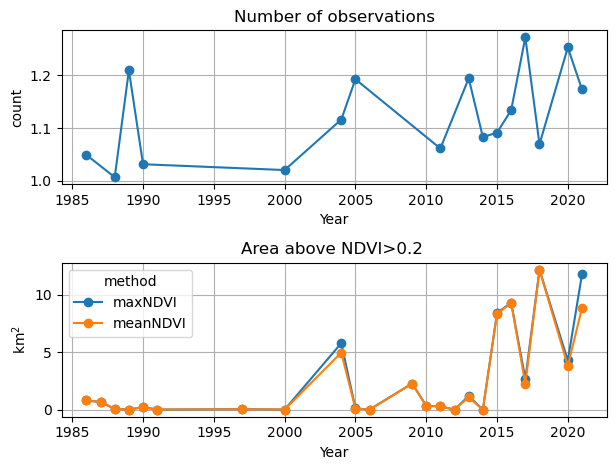

In [11]:
dcy = dc.groupby(by='method').agg(np.nanmean).filter(regex='NDVI').T
dcy.index = pd.to_datetime(dcy.index,format='NDVI_Area_%Y').year
fig,ax = plt.subplots(nrows=2,ncols=1)
dcy.plot(ax=ax[0],
        legend=None,
        title='Number of observations',
        marker='o',
        ylabel='count',
        xlabel='Year',
        grid=True);
dfy.plot(ax=ax[1],
        title='Area above NDVI>0.2 ',
        marker='o',
        ylabel='km$^2$',
        xlabel='Year',
        grid=True);
plt.tight_layout()

check correlation between number of observations and vegetation area

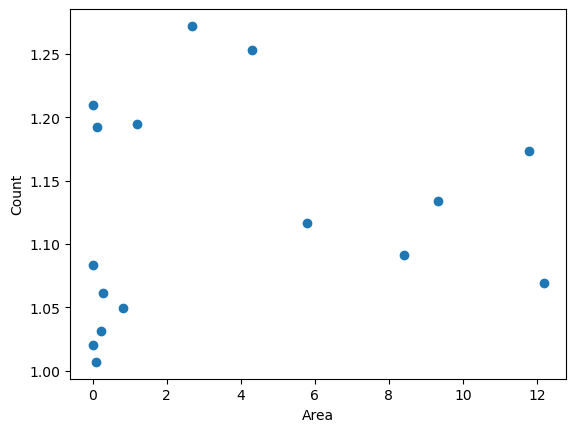

In [12]:
plt.scatter(dfy.maxNDVI.loc[dcy.index],dcy.loc[dcy.index])
plt.xlabel('Area')
plt.ylabel('Count');

## Analysis by hexagon

In [13]:
# "Trend analysis was conducted on the maximum annual area, with no-data years treated as zeroes, using a 1 year time interval"
# NB) in theory MK test does not require regularly spaced samples
def mktest_by_row(row):
    '''
    Mann-Kendall z and p (called tau in R24) for a given polygon
    '''
    ds = row.filter(regex='NDVI')
    #ds.index = pd.to_datetime(ds.index,format='NDVI_Area_%Y').year
    #ndvi = ds.reindex(range(1986,2022), fill_value=0)
    ndvi = ds.values
    test = mk.original_test(ndvi)
    return pd.Series(index=test._fields, data=test).rename(lambda x:'MK '+x)

In [14]:
def lstrend_by_row(row):
    '''
    Slope of the least-square regression line for a given polygon
    '''
    ds = row.filter(regex='NDVI')
    year = np.array(pd.to_datetime(ds.index,format='NDVI_Area_%Y').year)
    ndvi = np.array(ds.filter(regex='NDVI'), dtype=float)
    return pd.Series({'LS slope':np.polyfit(year,ndvi,1)[0]})

In [15]:
dmk = pd.concat([
    df,
    df.apply(mktest_by_row, axis=1, result_type='expand'),
    df.apply(lstrend_by_row, axis=1)
], axis=1)

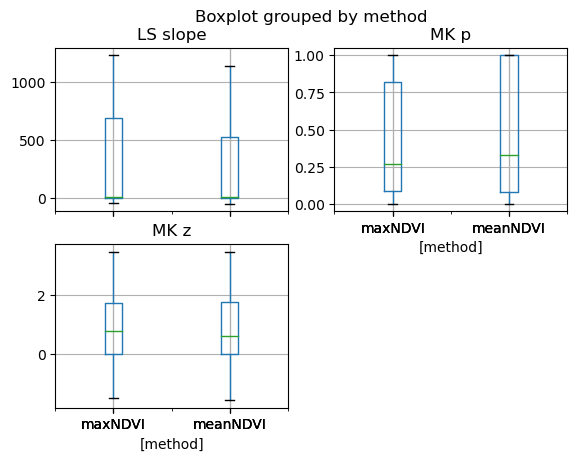

In [16]:
dmk[['MK z','MK p','LS slope','method']].boxplot(by='method', showfliers=False, sharey=False);

In [20]:
# export 1-p in % for visualization in QGIS (using hexagon id as joint key)
(100-100*dmk.query("method=='maxNDVI'")['MK p']).to_csv('confidence_maxNDVI.csv')
(100-100*dmk.query("method=='meanNDVI'")['MK p']).to_csv('confidence_meanNDVI.csv')

![Map of confidence](https://github.com/sgascoin/antarcticGreening/blob/main/antarcticGreening.jpeg)

## Misc

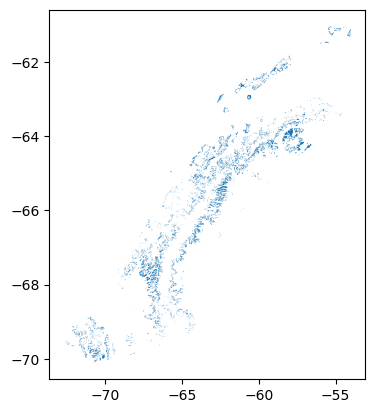

In [232]:
# NB) code to read as a geodataframe (using geometries)
import geopandas as gpd
from shapely.geometry import shape
import json
df0 = pd.read_csv('GAP_maxNDVI_Area.csv', index_col='system:index', converters={'.geo': json.loads})
gdf = gpd.GeoDataFrame(df0, geometry = df0.pop(".geo").apply(lambda x: shape(x)), crs='EPSG:4326')
gdf.geometry.plot();